In [0]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import networkx as nx
import numpy as np
import math
import random
from scipy.stats import loguniform

In [2]:
pip install hpbandster

     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 972kB 29.4MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp36-none-any.whl size=80007 sha256=9bfc24ec27bbc9dfc221c104e134e74c51b36aba02165a4a5565c4769f48122e
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.13-cp36-cp36m-linux_x86_64.whl size=2914641 sha256=fa09c9b141c7f253ad9d1a3a7f253e98a88cd84d20d1e1e963bb3c26adfb6554
  Stored in directory: /root/.cache/pip/wheels/9e/13/67/89f852e4a5cf173e6c7da5e9d449b8e98483bc8168cf7b6e6d
Successfully built hpbandster ConfigSpace


In [0]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

from hpbandster.core.worker import Worker

import logging
logging.basicConfig(level=logging.DEBUG)# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def set_seed(seed): 
 torch.backends.cudnn.deterministic = True 
 torch.backends.cudnn.benchmark = False 
 torch.manual_seed(seed)
 torch.cuda.manual_seed_all(seed)
 np.random.seed(seed) 
 random.seed(seed)

def unset_seed():  
 np.random.seed() 
 random.seed() 

In [0]:
class PyTorchWorker(Worker):
    def __init__(self, N_train = 8192, N_valid = 1024, **kwargs):
            super().__init__(**kwargs)

            batch_size = 64

            # Load the MNIST Data here
            train_dataset = torchvision.datasets.MNIST(root='../../data', train=True, transform=transforms.ToTensor(), download=True)
            test_dataset = torchvision.datasets.MNIST(root='../../data', train=False, transform=transforms.ToTensor())
            
            
            indices = list(range(N_train+N_valid))
            set_seed(10)                       #Random generation is made deterministic, we get same performance for specific lr always
            np.random.shuffle(indices)             

            train_idx, valid_idx = indices[N_valid:], indices[:N_valid]
            train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
            validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

            self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
            self.validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, sampler=validation_sampler)

            self.test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)


    def compute(self, config, budget, working_directory, *args, **kwargs):
            """
            Simple example for a compute function using a feed forward network.
            It is trained on the MNIST dataset.
            The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
            """

            # device = torch.device('cpu')
            model = LeNet().to(device)
            criterion = torch.nn.CrossEntropyLoss()
            if config['optimizer'] == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
            else:
                    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])

             
            
            for epoch in range(int(budget)):
                    loss = 0
                    model.train()
                    for i, (x, y) in enumerate(self.train_loader):
                            x = x.to(device)
                            y = y.to(device)
                            output = model(x)
                            
                            loss = criterion(output, y) 
                            
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

            train_accuracy = self.evaluate_accuracy(model, self.train_loader)
            validation_accuracy = self.evaluate_accuracy(model, self.validation_loader)
            test_accuracy = self.evaluate_accuracy(model, self.test_loader)
            num_params = model.number_of_parameters()

            return ({
                    'loss': 1-validation_accuracy, # remember: HpBandSter always minimizes!
                    'info': {       'test accuracy': test_accuracy,
                                            'train accuracy': train_accuracy,
                                            'validation accuracy': validation_accuracy,
                                            'number of parameters': num_params,
                                    }

            })

    def evaluate_accuracy(self, model, data_loader):
            model.eval()
            correct=0
            with torch.no_grad():
                    for x, y in data_loader:
                            x = x.to(device)
                            y = y.to(device)
                            output = model(x)
                            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                            correct += pred.eq(y.view_as(pred)).sum().item()
           
            accuracy = correct/len(data_loader.sampler)
            return(accuracy)


In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
    self.conv2 = nn.Conv2d(6, 16, (5,5))
    self.fc1   = nn.Linear(16*5*5, 120)
    self.fc2   = nn.Linear(120, 84)
    self.fc3   = nn.Linear(84, 10)
  
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

  def number_of_parameters(self):
    return(sum(p.numel() for p in self.parameters() if p.requires_grad))  


Setting up Graph for ACO

In [0]:
class Graph:

    def __init__(self,num_lr):
      self.num_lr = num_lr
      
    
    def generate_graph(self):
      G = nx.DiGraph()        #Directional graph
      edges=[]
      G.add_node('inp')
      G.add_node('out')

      set_seed(10)

      rvs_lr = loguniform.rvs(1e-6, 1e-1, size=self.num_lr)

      for lr in range(self.num_lr):
        #learning_rate = random.uniform(1e-6, 1e-1)
        G.add_node(lr, lr=rvs_lr[lr])
        edge = ['inp',lr,1]                     #initial weight is 1 (pheromone value)
        edges.append(edge)
        edge = [lr,'out',1]
        edges.append(edge)
     # for dr in range(self.num_dr):
     #  dropout_rate = random.uniform(0.0, 0.9)
     #  G.add_node(dr+self.num_lr, dr=dropout_rate)
     #  for lr in range(self.num_lr):
     #    edge = [lr,dr+self.num_lr,1]
     #    edges.append(edge)

     # for nfu in range(self.num_num_fc_units): 
     #  num_fc_units = random.randint(8, 256)
     #  G.add_node(nfu+self.num_lr+self.num_dr, nfu=num_fc_units)
     #  edge = [nfu+self.num_lr+self.num_dr,'out',1]
     #  edges.append(edge)
     #  for dr in range(self.num_dr):
     #    edge = [dr+self.num_lr,(nfu+self.num_lr+self.num_dr),1]
     #    edges.append(edge)

      G.add_weighted_edges_from(edges)
    
      return G


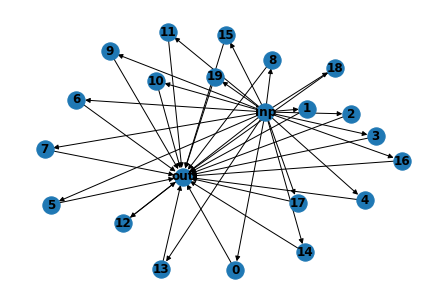

In [30]:
Graphed = Graph(20)
G = Graphed.generate_graph()
nx.draw(G,with_labels=True,font_weight='bold')

In [31]:
list(G.nodes.data())

[('inp', {}),
 ('out', {}),
 (0, {'lr': 0.007187919693377487}),
 (1, {'lr': 1.2698714136216185e-06}),
 (2, {'lr': 0.00147313034159888}),
 (3, {'lr': 0.005546505049361993}),
 (4, {'lr': 0.00031083868392602}),
 (5, {'lr': 1.3304030371488219e-05}),
 (6, {'lr': 9.779447595326338e-06}),
 (7, {'lr': 0.006348243270946389}),
 (8, {'lr': 7.00735601561879e-06}),
 (9, {'lr': 2.765025054332624e-06}),
 (10, {'lr': 0.00267177014012544}),
 (11, {'lr': 0.05847452881552237}),
 (12, {'lr': 1.046505057794038e-06}),
 (13, {'lr': 0.0003638826232716773}),
 (14, {'lr': 0.011563912803570744}),
 (15, {'lr': 0.001155128593079558}),
 (16, {'lr': 0.004062342974817011}),
 (17, {'lr': 2.87991944958616e-05}),
 (18, {'lr': 0.03880347432921835}),
 (19, {'lr': 0.003740062993057816})]

In [32]:
list(G.edges.data())

[('inp', 0, {'weight': 1}),
 ('inp', 1, {'weight': 1}),
 ('inp', 2, {'weight': 1}),
 ('inp', 3, {'weight': 1}),
 ('inp', 4, {'weight': 1}),
 ('inp', 5, {'weight': 1}),
 ('inp', 6, {'weight': 1}),
 ('inp', 7, {'weight': 1}),
 ('inp', 8, {'weight': 1}),
 ('inp', 9, {'weight': 1}),
 ('inp', 10, {'weight': 1}),
 ('inp', 11, {'weight': 1}),
 ('inp', 12, {'weight': 1}),
 ('inp', 13, {'weight': 1}),
 ('inp', 14, {'weight': 1}),
 ('inp', 15, {'weight': 1}),
 ('inp', 16, {'weight': 1}),
 ('inp', 17, {'weight': 1}),
 ('inp', 18, {'weight': 1}),
 ('inp', 19, {'weight': 1}),
 (0, 'out', {'weight': 1}),
 (1, 'out', {'weight': 1}),
 (2, 'out', {'weight': 1}),
 (3, 'out', {'weight': 1}),
 (4, 'out', {'weight': 1}),
 (5, 'out', {'weight': 1}),
 (6, 'out', {'weight': 1}),
 (7, 'out', {'weight': 1}),
 (8, 'out', {'weight': 1}),
 (9, 'out', {'weight': 1}),
 (10, 'out', {'weight': 1}),
 (11, 'out', {'weight': 1}),
 (12, 'out', {'weight': 1}),
 (13, 'out', {'weight': 1}),
 (14, 'out', {'weight': 1}),
 (15,

In [0]:
class ACO:

    def __init__(self, num_ants, Graph):
         self.num_ants = num_ants
         self.G = Graph

    def generate_ants(self): 
         best_path = []
         best_loss = math.inf

         paths = []
         for i in range(self.num_ants):
             unset_seed()         #remove seed, while finding aco path
             path = self.select_aco_path()
             self.local_pheromone_update(path)
             print(path)
             paths.append(path)
             result = self.evaluation(path) 
             if (result['loss'] < best_loss):
              best_path = path
              best_loss = result['loss']

         print("Group of ants have traversed")
         print(paths)
         self.global_pheromone_update(paths,best_path,best_loss)

         result = {
             "best_path": best_path,
             "best_loss": best_loss
         }
         return result


    def select_aco_path(self):
        """Selects ant path from source to destination based on ACO select rule"""
        ant_path = []
        current_node = 'inp' 
        ant_path.append(current_node)
        next_node = 'inp'

        while(next_node!='out'):
         next_node = self.aco_select_rule(current_node)
         current_node = next_node
         ant_path.append(next_node)
        
        return ant_path    

    def aco_select_rule(self, current_node):
        """Selects neigbour using ACO transition rule"""
        

        probabilities = []
        denominator = 0.0
        greediness = 0.5
        neighbours = list(G.successors(current_node))
        # Calculate probability for each neighbour    (heuristics are not considered)
        for i in range(len(neighbours)):
            probability = self.G[current_node][neighbours[i]]['weight']    #pheromone value
            probabilities.append(probability)
            denominator += probability

        # Try to perform greedy select: exploitation
        random_variable = random.uniform(0, 1)
        if random_variable <= greediness:
            # Find max probability
            max_probability = max(probabilities)
            # Gather the indices of probabilities that are equal to the max probability
            max_indices = [i for i, j in enumerate(probabilities) if j == max_probability]
            # From those max indices select random index
            neighbour_index = random.choice(max_indices)
            return neighbours[neighbour_index]

        # Otherwise perform select using roulette wheel: exploration
        probabilities = [x / denominator for x in probabilities]
        probability_sum = sum(probabilities)
        random_threshold = random.uniform(0, probability_sum)
        current_value = 0
        for neighbour_index, probability in enumerate(probabilities):
            current_value += probability
            if current_value > random_threshold:
                return neighbours[neighbour_index]

    def local_pheromone_update(self,path):      
        pheromone_0 = 0.1
        decay = 0.1
        for i in range(len(path)-1):
          self.G[path[i]][path[i+1]]['weight'] = (1 - decay) * self.G[path[i]][path[i+1]]['weight'] + (decay * pheromone_0)
    
    def global_pheromone_update(self, paths, best_path, best_loss):
        evaporation = 0.1
        added_pheromone = 1 - best_loss    #best_accuracy
        for i in range(self.num_ants):
          if(best_path != paths[i]):
             for k in range(len(paths[i])-1):
               self.G[paths[i][k]][paths[i][k+1]]['weight'] = (1 - evaporation) * self.G[paths[i][k]][paths[i][k+1]]['weight']

        for i in range(len(best_path)-1):     #deposit pheromone for the best path only
          self.G[best_path[i]][best_path[i+1]]['weight'] = (1 - evaporation) * self.G[best_path[i]][best_path[i+1]]['weight'] + (evaporation * added_pheromone)

    def evaluation(self,path):
       lr = G.nodes[path[1]]['lr']
       config = {
           'lr': lr,
           'optimizer': 'Adam'
       }
       print(config)
       worker = PyTorchWorker(run_id='0')
       res = worker.compute(config=config, budget=10, working_directory='.')
       print(res)
       return res

In [34]:
num_of_ants = 10
acs=ACO(num_of_ants,G)

result_first_group = acs.generate_ants()
print(result_first_group)

['inp', 2, 'out']
{'lr': 0.00147313034159888, 'optimizer': 'Adam'}
{'loss': 0.029296875, 'info': {'test accuracy': 0.9699, 'train accuracy': 0.990478515625, 'validation accuracy': 0.970703125, 'number of parameters': 61706}}
['inp', 2, 'out']
{'lr': 0.00147313034159888, 'optimizer': 'Adam'}
{'loss': 0.029296875, 'info': {'test accuracy': 0.9699, 'train accuracy': 0.990478515625, 'validation accuracy': 0.970703125, 'number of parameters': 61706}}
['inp', 12, 'out']
{'lr': 1.046505057794038e-06, 'optimizer': 'Adam'}
{'loss': 0.806640625, 'info': {'test accuracy': 0.1626, 'train accuracy': 0.1767578125, 'validation accuracy': 0.193359375, 'number of parameters': 61706}}
['inp', 15, 'out']
{'lr': 0.001155128593079558, 'optimizer': 'Adam'}
{'loss': 0.033203125, 'info': {'test accuracy': 0.9705, 'train accuracy': 0.982666015625, 'validation accuracy': 0.966796875, 'number of parameters': 61706}}
['inp', 6, 'out']
{'lr': 9.779447595326338e-06, 'optimizer': 'Adam'}
{'loss': 0.404296875, 'info'

In [35]:
list(G.edges.data())

[('inp', 0, {'weight': 1}),
 ('inp', 1, {'weight': 0.8190000000000001}),
 ('inp', 2, {'weight': 0.7775603125000001}),
 ('inp', 3, {'weight': 1}),
 ('inp', 4, {'weight': 0.8190000000000001}),
 ('inp', 5, {'weight': 1}),
 ('inp', 6, {'weight': 0.8190000000000001}),
 ('inp', 7, {'weight': 1}),
 ('inp', 8, {'weight': 1}),
 ('inp', 9, {'weight': 0.8190000000000001}),
 ('inp', 10, {'weight': 1}),
 ('inp', 11, {'weight': 1}),
 ('inp', 12, {'weight': 0.8190000000000001}),
 ('inp', 13, {'weight': 1}),
 ('inp', 14, {'weight': 1}),
 ('inp', 15, {'weight': 0.8190000000000001}),
 ('inp', 16, {'weight': 1}),
 ('inp', 17, {'weight': 0.8190000000000001}),
 ('inp', 18, {'weight': 1}),
 ('inp', 19, {'weight': 1}),
 (0, 'out', {'weight': 1}),
 (1, 'out', {'weight': 0.8190000000000001}),
 (2, 'out', {'weight': 0.7775603125000001}),
 (3, 'out', {'weight': 1}),
 (4, 'out', {'weight': 0.8190000000000001}),
 (5, 'out', {'weight': 1}),
 (6, 'out', {'weight': 0.8190000000000001}),
 (7, 'out', {'weight': 1}),
 (

In [36]:
result_second_group = acs.generate_ants()
print(result_second_group)

['inp', 18, 'out']
{'lr': 0.03880347432921835, 'optimizer': 'Adam'}
{'loss': 0.8916015625, 'info': {'test accuracy': 0.0958, 'train accuracy': 0.1005859375, 'validation accuracy': 0.1083984375, 'number of parameters': 61706}}
['inp', 13, 'out']
{'lr': 0.0003638826232716773, 'optimizer': 'Adam'}
{'loss': 0.0400390625, 'info': {'test accuracy': 0.9618, 'train accuracy': 0.9683837890625, 'validation accuracy': 0.9599609375, 'number of parameters': 61706}}
['inp', 13, 'out']
{'lr': 0.0003638826232716773, 'optimizer': 'Adam'}
{'loss': 0.0400390625, 'info': {'test accuracy': 0.9618, 'train accuracy': 0.9683837890625, 'validation accuracy': 0.9599609375, 'number of parameters': 61706}}
['inp', 5, 'out']
{'lr': 1.3304030371488219e-05, 'optimizer': 'Adam'}
{'loss': 0.3046875, 'info': {'test accuracy': 0.692, 'train accuracy': 0.6962890625, 'validation accuracy': 0.6953125, 'number of parameters': 61706}}
['inp', 5, 'out']
{'lr': 1.3304030371488219e-05, 'optimizer': 'Adam'}
{'loss': 0.3046875, '

In [37]:
list(G.edges.data())

[('inp', 0, {'weight': 1}),
 ('inp', 1, {'weight': 0.8190000000000001}),
 ('inp', 2, {'weight': 0.7775603125000001}),
 ('inp', 3, {'weight': 0.9164609375000001}),
 ('inp', 4, {'weight': 0.8190000000000001}),
 ('inp', 5, {'weight': 0.5511969000000001}),
 ('inp', 6, {'weight': 0.8190000000000001}),
 ('inp', 7, {'weight': 1}),
 ('inp', 8, {'weight': 0.8190000000000001}),
 ('inp', 9, {'weight': 0.6723900000000002}),
 ('inp', 10, {'weight': 1}),
 ('inp', 11, {'weight': 1}),
 ('inp', 12, {'weight': 0.8190000000000001}),
 ('inp', 13, {'weight': 0.6714900000000001}),
 ('inp', 14, {'weight': 1}),
 ('inp', 15, {'weight': 0.8190000000000001}),
 ('inp', 16, {'weight': 1}),
 ('inp', 17, {'weight': 0.6723900000000002}),
 ('inp', 18, {'weight': 0.8190000000000001}),
 ('inp', 19, {'weight': 1}),
 (0, 'out', {'weight': 1}),
 (1, 'out', {'weight': 0.8190000000000001}),
 (2, 'out', {'weight': 0.7775603125000001}),
 (3, 'out', {'weight': 0.9164609375000001}),
 (4, 'out', {'weight': 0.8190000000000001}),
 

In [38]:
result_third_group = acs.generate_ants()
print(result_third_group)

['inp', 9, 'out']
{'lr': 2.765025054332624e-06, 'optimizer': 'Adam'}
{'loss': 0.6494140625, 'info': {'test accuracy': 0.3146, 'train accuracy': 0.32861328125, 'validation accuracy': 0.3505859375, 'number of parameters': 61706}}
['inp', 14, 'out']
{'lr': 0.011563912803570744, 'optimizer': 'Adam'}
{'loss': 0.03125, 'info': {'test accuracy': 0.957, 'train accuracy': 0.98388671875, 'validation accuracy': 0.96875, 'number of parameters': 61706}}
['inp', 7, 'out']
{'lr': 0.006348243270946389, 'optimizer': 'Adam'}
{'loss': 0.0263671875, 'info': {'test accuracy': 0.9724, 'train accuracy': 0.992919921875, 'validation accuracy': 0.9736328125, 'number of parameters': 61706}}
['inp', 11, 'out']
{'lr': 0.05847452881552237, 'optimizer': 'Adam'}
{'loss': 0.8916015625, 'info': {'test accuracy': 0.0958, 'train accuracy': 0.1005859375, 'validation accuracy': 0.1083984375, 'number of parameters': 61706}}
['inp', 11, 'out']
{'lr': 0.05847452881552237, 'optimizer': 'Adam'}
{'loss': 0.8916015625, 'info': {'

In [39]:
list(G.edges.data())

[('inp', 0, {'weight': 0.8190000000000001}),
 ('inp', 1, {'weight': 0.6723900000000002}),
 ('inp', 2, {'weight': 0.6388238531250001}),
 ('inp', 3, {'weight': 0.9164609375000001}),
 ('inp', 4, {'weight': 0.8190000000000001}),
 ('inp', 5, {'weight': 0.5511969000000001}),
 ('inp', 6, {'weight': 0.8190000000000001}),
 ('inp', 7, {'weight': 0.8190000000000001}),
 ('inp', 8, {'weight': 0.8190000000000001}),
 ('inp', 9, {'weight': 0.5536359000000001}),
 ('inp', 10, {'weight': 0.8190000000000001}),
 ('inp', 11, {'weight': 0.6714900000000001}),
 ('inp', 12, {'weight': 0.8190000000000001}),
 ('inp', 13, {'weight': 0.6714900000000001}),
 ('inp', 14, {'weight': 0.8190000000000001}),
 ('inp', 15, {'weight': 0.8190000000000001}),
 ('inp', 16, {'weight': 0.9169492187500001}),
 ('inp', 17, {'weight': 0.6723900000000002}),
 ('inp', 18, {'weight': 0.8190000000000001}),
 ('inp', 19, {'weight': 1}),
 (0, 'out', {'weight': 0.8190000000000001}),
 (1, 'out', {'weight': 0.6723900000000002}),
 (2, 'out', {'wei

In [40]:
print(result_first_group)
print(result_second_group)
print(result_third_group)

{'best_path': ['inp', 2, 'out'], 'best_loss': 0.029296875}
{'best_path': ['inp', 3, 'out'], 'best_loss': 0.025390625}
{'best_path': ['inp', 16, 'out'], 'best_loss': 0.0205078125}


In [41]:
for key, value in result_first_group.items():
 if key == 'best_loss':
   min_best_loss = min(value,result_second_group[key],result_third_group[key])

if(result_first_group['best_loss']==min_best_loss):
   overall_best_path = result_first_group['best_path']

elif(result_second_group['best_loss']==min_best_loss):
   overall_best_path = result_second_group['best_path']   

elif(result_third_group['best_loss']==min_best_loss):
   overall_best_path = result_third_group['best_path']   

print("Best path among the groups")
print(overall_best_path)
print("Best Learning rate")
print(G.nodes[overall_best_path[1]]['lr'])
print("Best validation Accuracy")
print(1-min_best_loss)

Best path among the groups
['inp', 16, 'out']
Best Learning rate
0.004062342974817011
Best validation Accuracy
0.9794921875
